## Tweets Analysis - Recession ###

NB on text processing and sentiment analysis

In [127]:
import tweepy
import datetime
import pandas as pd
import re
import numpy as np
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator
from langdetect import detect
from wordcloud import WordCloud,ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\01914M744\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\01914M744\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\01914M744\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [128]:
query = '#recession -is:retweet'
tw_clnt=tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAEL6VwEAAAAAZ6UjsuGOJSbpEmpFJBaQPlaimNY%3DCUJce6Bfo0jltUA9FscvXXibtAp3ZLCfGTwXxFdrMK5VnQ7x7K')
tweets2=tweepy.Paginator(tw_clnt.search_recent_tweets,query, max_results=100).flatten(limit=1800)

#search_recent_tweets
df_tweets=pd.DataFrame(tweets2)


In [129]:
df_tweets.sample(2)

,edit_history_tweet_ids,id,text
626,[1593862217434337280],1593862217434337280,"⚠ Top 10 Macro/Financial Charts of the Week – w46 ⚠\n\n*HT @Lvieweconomics, @MikeZaccardi\n\n#Recession #Bonds #Rents #Inflation #Shipping #Germany\n\nhttps://t.co/bkKDHtgfa7"
1459,[1593434960035483648],1593434960035483648,"#GlobalMarkets | डॉलर में मजबूती ने कच्चे तेल पर बनाया दबाव, क्या कहते हैं ग्लोबल सकेंत, जानिए @NeerajCNBC से। \n\n#USHousingSector #FederalReserve #CrudeOil #dollar #recessioninUK #recession https://t.co/MuqszgJZ3R"


In [130]:
df_tweets.count(), df_tweets.isnull().sum()

(edit_history_tweet_ids    1800
 id                        1800
 text                      1800
 dtype: int64,
 edit_history_tweet_ids    0
 id                        0
 text                      0
 dtype: int64)

In [131]:
df=df_tweets.copy()

####  Data Cleaning

bkp
    #text=re.sub("@[A-Za-z0-9_]+","", x)        # Removing mentions in the text
    #text=re.sub("#[A-Za-z0-9_]+","", text)     # Removing hashtags in the text

In [132]:
def tweet_cleaner(x):
    #text=re.sub("[#@&][A-Za-z0-9_]+","", x)      # Removing mentions and hashtags and &amp,
    text=re.sub("[@&][A-Za-z0-9_]+","", x)       # Removing only mentions  and &amp, while 'hashtags' have some information
    text=re.sub(r"http\S+","", text)
    return  pd.Series([text])

df[['plain_text']] = df.text.apply(tweet_cleaner)

## Extracting media from text  --> media=re.findall(r"http\S+", text)

#Converting all text to lowercase
df.plain_text = df.plain_text.str.lower()

#Remove newline character
df.plain_text = df.plain_text.str.replace('\n', '')  


In [133]:
df.sample(2)

,edit_history_tweet_ids,id,text,plain_text
96,[1594295786480832512],1594295786480832512,"The year 2023 is quickly approaching, so now is a good time for marketers to start getting ready for some of the possible outcomes. \n\nRead more: https://t.co/jKE2Upb0pP\n\n#MarketingChallenges #EconomicTimes #MarketingBudget #Recession #2023 https://t.co/2ipNFCpCAi","the year 2023 is quickly approaching, so now is a good time for marketers to start getting ready for some of the possible outcomes. read more: #marketingchallenges #economictimes #marketingbudget #recession #2023"
1118,[1593587652569145349],1593587652569145349,"Nice visualization of P/E expansion once #recession sets in. Investors begin to anticipate earnings rebound, multiples EXPAND. \n\nUsual signal is a trough in Industrial Production. \n\n#Macro #investing $SPX $SPY https://t.co/4j5GW4o3dC","nice visualization of p/e expansion once #recession sets in. investors begin to anticipate earnings rebound, multiples expand. usual signal is a trough in industrial production. #macro #investing $spx $spy"


Replacing empty strings with null 


In [134]:
#Replacing empty strings with null
df = df.replace(r'^\s*$', np.nan, regex=True)
if df.isnull().sum().plain_text == 0:
    print ('no empty strings')
else:
    df.dropna(inplace=True)


no empty strings


In [135]:
df.drop(['edit_history_tweet_ids', 'id'], axis=1,inplace=True)
#df.drop(['withheld'], axis=1,inplace=True)

In [136]:
#detect language of tweets
def detect_textlang(text):
    try:
        src_lang = detect(text)
        if src_lang =='en':
            return 'en'
        else:
        #return "NA"    
            return src_lang
    except:
        return "NA"
df['text_lang']=df.plain_text.apply(detect_textlang)

In [137]:
#Inspecting NA records and dropping them if they exist
if df[df.text_lang == 'NA'].text_lang.count() != 0:
    df.drop(df[df.text_lang == 'NA'].index, inplace=True) 
    print('Deleted records with no character ')

In [138]:
df[df.text_lang != 'en'].sample()

,text,plain_text,text_lang
85,ముంచుకొస్తున్న ఆర్థిక మాంద్యం.. మానసిక ఆరోగ్యంపై ప్రభావం.. నిపుణులు ఏం చెబుతున్నారంటే..\n\n#Recession #Layoffs #Jobs\n\nhttps://t.co/vN8ZCa48LT,ముంచుకొస్తున్న ఆర్థిక మాంద్యం.. మానసిక ఆరోగ్యంపై ప్రభావం.. నిపుణులు ఏం చెబుతున్నారంటే..#recession #layoffs #jobs,te


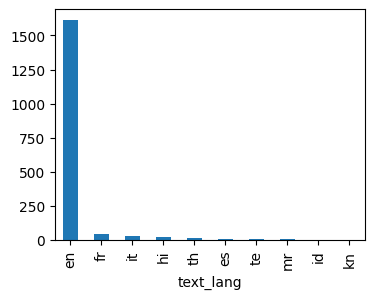

In [139]:
# Group number of tweets by language and list the top 10
plt.figure(figsize=(4,3))
df.groupby(df.text_lang).plain_text.count().sort_values(ascending=False).head(10).plot.bar()
plt.show()

In [140]:
def translate_text(lang,text):
    translator= Translator()
    trans_text = translator.translate(text, src=lang).text
    return trans_text


df['translated_text']=df.apply(lambda x: x.plain_text if x.text_lang == 'en' else translate_text(x.text_lang, x.plain_text), axis=1)
df.translated_text = df.translated_text.str.lower()

In [141]:
df[df.text_lang == 'es'].sample()

,text,plain_text,text_lang,translated_text
1606,"🌐¿Qué es una recesión económica?\nDesde el punto de vista técnico, cuando el producto interno bruto de un país decrece durante seis meses seguidos se estaría hablando de una recesión. A partir de aquí la oferta de bienes y servicios disminuye drásticamente... #NoAlNOM #recession https://t.co/dHBiZEaLRd","🌐¿qué es una recesión económica?desde el punto de vista técnico, cuando el producto interno bruto de un país decrece durante seis meses seguidos se estaría hablando de una recesión. a partir de aquí la oferta de bienes y servicios disminuye drásticamente... #noalnom #recession",es,"🌐 what is an economic recession? from the technical point of view, when the gross domestic product of a country decreases for six months in a row would be talking about a recession.from here the offer of goods and services decreases dramatically ... #noalnom #recession"


Translate non english text

In [142]:
#df.drop(['text'], axis=1, inplace=True)
df2=df.copy()

In [143]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
query_words={'recession', '#'}
stop_words.update(query_words)

for word in query_words:
    df2.translated_text = df2.translated_text.str.replace(word, '')
    

In [144]:
concat_data=' '.join(df2.translated_text)

In [145]:
!pip install Counter


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [146]:
#Get the frequency of words
new_tokens = word_tokenize(concat_data)
new_tokens = [t.lower() for t in new_tokens]
new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
new_tokens = [t for t in new_tokens if t.isalpha()]


lemmatizer = WordNetLemmatizer()
new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]

#counts the words
counted = Counter(new_tokens)
word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

word_freq.head(5)

,word,frequency
333,layoff,420
78,inflation,382
26,economy,272
159,job,234
1087,thelayoff,145


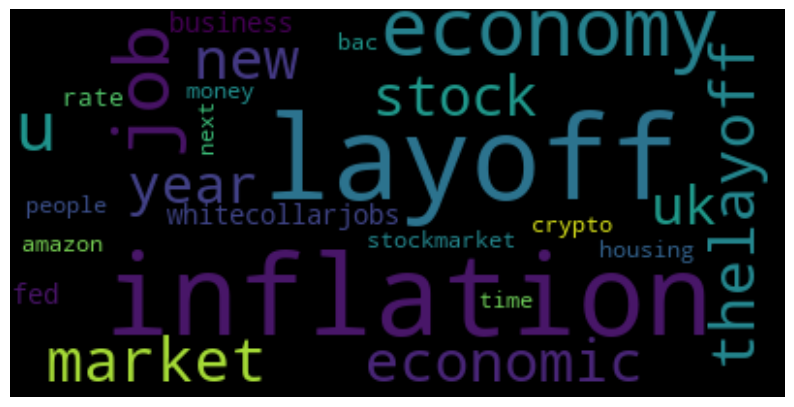

In [147]:
wc=WordCloud(stopwords=stop_words, collocations=False, max_font_size=60, max_words=25, background_color="black")
wc.generate(concat_data)
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [148]:
analyzer=SentimentIntensityAnalyzer()        
df2['polarity']=[analyzer.polarity_scores(text)['compound'] for text in df2.translated_text]

df2.sample(5)

,text,plain_text,text_lang,translated_text,polarity
1467,#Midterms2022results \n#recession \n#EnergyCrisis \n#FarmersProtest \n#MarALago \n#FBICorruption \n#HunterBideniPhone \n#Migration \n#healthcare \n#Railroadstrike\n#TeachersDay \n#VaccineDeaths \n#EnoughIsEnough \n#freedomrally \n#Agenda2030 \n#GreatReset \n#EuropeProtest\n#Inflation\n#depression,#midterms2022results #recession #energycrisis #farmersprotest #maralago #fbicorruption #hunterbideniphone #migration #healthcare #railroadstrike#teachersday #vaccinedeaths #enoughisenough #freedomrally #agenda2030 #greatreset #europeprotest#inflation#depression,en,midterms2022results energycrisis farmersprotest maralago fbicorruption hunterbideniphone migration healthcare railroadstriketeachersday vaccinedeaths enoughisenough freedomrally agenda2030 greatreset europeprotestinflationdepression,0.0000
167,https://t.co/jCe928kALG\n3M\nDo any 3M executives read this site?\n#threem #mmm $mmm #SaintPaul #MN #minnesota #minnesotajobs #minnesotalayoffs #saintpaullayoffs #jobs #recession #whitecollarjobs #layoff #layoffs #thelayoff 🤖,3mdo any 3m executives read this site?#threem #mmm $mmm #saintpaul #mn #minnesota #minnesotajobs #minnesotalayoffs #saintpaullayoffs #jobs #recession #whitecollarjobs #layoff #layoffs #thelayoff 🤖,en,3mdo any 3m executives read this site?threem mmm $mmm saintpaul mn minnesota minnesotajobs minnesotalayoffs saintpaullayoffs jobs whitecollarjobs layoff layoffs thelayoff 🤖,0.0000
1637,"Now that we are in a #recession and the #Michigan #unemployment system is still broken, and the same idiot is at the helm, how long before all hell breaks loose when people are losing their jobs left and right in the next six months here? Let the games begin.","now that we are in a #recession and the #michigan #unemployment system is still broken, and the same idiot is at the helm, how long before all hell breaks loose when people are losing their jobs left and right in the next six months here? let the games begin.",en,"now that we are in a and the michigan unemployment system is still broken, and the same idiot is at the helm, how long before all hell breaks loose when people are losing their jobs left and right in the next six months here? let the games begin.",-0.9571
435,History of #Construction Unemployment Rates in Canada's Provinces #Charts #Commentary https://t.co/9jdbRGn6of #economy #banking #business #developers #steel #lumber #cement #inflation #recession #ConstructConnx @ConstructConnx @DCN_Canada https://t.co/1JCM5NqwDs,history of #construction unemployment rates in canada's provinces #charts #commentary #economy #banking #business #developers #steel #lumber #cement #inflation #recession #constructconnx,en,history of construction unemployment rates in canada's provinces charts commentary economy banking business developers steel lumber cement inflation constructconnx,-0.4404
563,https://t.co/8PYIO3sOzM\nAvaya\nBankruptcy next week\n$AVYA #avaya #communications #techjobs #joblosses #recessionlayoffs #jobs #recession #whitecollarjobs #layoff #layoffs #thelayoff #Durham #NC #northcarolina 🤖,avayabankruptcy next week$avya #avaya #communications #techjobs #joblosses #recessionlayoffs #jobs #recession #whitecollarjobs #layoff #layoffs #thelayoff #durham #nc #northcarolina 🤖,en,avayabankruptcy next week$avya avaya communications techjobs joblosses layoffs jobs whitecollarjobs layoff layoffs thelayoff durham nc northcarolina 🤖,0.0000


In [149]:
def get_sentiment(polarity):
    if polarity < 0.0:
        return 'Negative'
    elif polarity > 0.2:
        return 'Positive'
    else:
        return 'Neutral'

df2['sentiment']=df2.polarity.apply(get_sentiment)

<AxesSubplot: >

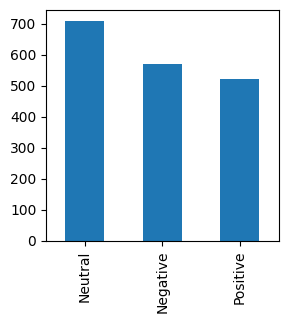

In [150]:
plt.figure(figsize=(3,3))
df2.sentiment.value_counts().plot.bar()

In [151]:
df2.sample()

,text,plain_text,text_lang,translated_text,polarity,sentiment
740,Mass layoffs are hurting many households. Recession has started globally. How Indians are prepared for it ? #recession #layoffs #Growth #employees #india,mass layoffs are hurting many households. recession has started globally. how indians are prepared for it ? #recession #layoffs #growth #employees #india,en,mass layoffs are hurting many households. has started globally. how indians are prepared for it ? layoffs growth employees india,0.2023,Positive


In [152]:
df2[df2.sentiment == 'Positive'].sample(2)

,text,plain_text,text_lang,translated_text,polarity,sentiment
994,6 Simple Tips To Help Survive And Thrive During Economic Volatility https://t.co/rOcGzhUAfm\n\n#Recession #Recessions #Recession2023 #Economy #Economics #Volatility #Market #Marketplace #BusinessOwner https://t.co/FkssmeVsTA,6 simple tips to help survive and thrive during economic volatility #recession #recessions #recession2023 #economy #economics #volatility #market #marketplace #businessowner,en,6 simple tips to help survive and thrive during economic volatility s 2023 economy economics volatility market marketplace businessowner,0.4019,Positive
1504,2022 Deferred Interest Study: Which Retailers Use It? https://t.co/BBiD2vLHVF #financialstress #socialwork #financialsocialwork #financialwellnesss #financialhealth #HOPE #NASW #SocialWorkTwitter #mentalhealth #inflation #recession #debt https://t.co/vLguC0aont,2022 deferred interest study: which retailers use it? #financialstress #socialwork #financialsocialwork #financialwellnesss #financialhealth #hope #nasw #socialworktwitter #mentalhealth #inflation #recession #debt,en,2022 deferred interest study: which retailers use it? financialstress socialwork financialsocialwork financialwellnesss financialhealth hope nasw socialworktwitter mentalhealth inflation debt,0.5267,Positive


In [153]:
import transformers
from transformers import pipeline

In [155]:
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["It is a lovely day today."]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998821020126343}]